# How to add a semantic layer over graph database

You can use database queries to retrieve information from a graph database like Neo4j.
One option is to use LLMs to generate Cypher statements.
While that option provides excellent flexibility, the solution could be brittle and not consistently generating precise Cypher statements.
Instead of generating Cypher statements, we can implement Cypher templates as tools in a semantic layer that an LLM agent can interact with.

![graph_semantic.png](../../static/img/graph_semantic.png)

## Setup

First, get required packages and set environment variables:

In [ ]:
%pip install --upgrade --quiet  langchain langchain-neo4j langchain-openai

We default to OpenAI models in this guide, but you can swap them out for the model provider of your choice.

In [1]:
import getpass
import os

os.environ["OPENAI_API_KEY"] = getpass.getpass()

# Uncomment the below to use LangSmith. Not required.
# os.environ["LANGSMITH_API_KEY"] = getpass.getpass()
# os.environ["LANGSMITH_TRACING"] = "true"

 ········


Next, we need to define Neo4j credentials.
Follow [these installation steps](https://neo4j.com/docs/operations-manual/current/installation/) to set up a Neo4j database.

In [2]:
os.environ["NEO4J_URI"] = "bolt://localhost:7687"
os.environ["NEO4J_USERNAME"] = "neo4j"
os.environ["NEO4J_PASSWORD"] = "password"

The below example will create a connection with a Neo4j database and will populate it with example data about movies and their actors.

In [3]:
from langchain_neo4j import Neo4jGraph

graph = Neo4jGraph(refresh_schema=False)

# Import movie information

movies_query = """
LOAD CSV WITH HEADERS FROM 
'https://raw.githubusercontent.com/tomasonjo/blog-datasets/main/movies/movies_small.csv'
AS row
MERGE (m:Movie {id:row.movieId})
SET m.released = date(row.released),
    m.title = row.title,
    m.imdbRating = toFloat(row.imdbRating)
FOREACH (director in split(row.director, '|') | 
    MERGE (p:Person {name:trim(director)})
    MERGE (p)-[:DIRECTED]->(m))
FOREACH (actor in split(row.actors, '|') | 
    MERGE (p:Person {name:trim(actor)})
    MERGE (p)-[:ACTED_IN]->(m))
FOREACH (genre in split(row.genres, '|') | 
    MERGE (g:Genre {name:trim(genre)})
    MERGE (m)-[:IN_GENRE]->(g))
"""

graph.query(movies_query)

[]

## Custom tools with Cypher templates

A semantic layer consists of various tools exposed to an LLM that it can use to interact with a knowledge graph.
They can be of various complexity. You can think of each tool in a semantic layer as a function.

The function we will implement is to retrieve information about movies or their cast.

In [4]:
description_query = """
MATCH (m:Movie|Person)
WHERE m.title CONTAINS $candidate OR m.name CONTAINS $candidate
MATCH (m)-[r:ACTED_IN|IN_GENRE]-(t)
WITH m, type(r) as type, collect(coalesce(t.name, t.title)) as names
WITH m, type+": "+reduce(s="", n IN names | s + n + ", ") as types
WITH m, collect(types) as contexts
WITH m, "type:" + labels(m)[0] + "\ntitle: "+ coalesce(m.title, m.name) 
       + "\nyear: "+coalesce(m.released,"") +"\n" +
       reduce(s="", c in contexts | s + substring(c, 0, size(c)-2) +"\n") as context
RETURN context LIMIT 1
"""


def get_information(entity: str) -> str:
    try:
        data = graph.query(description_query, params={"candidate": entity})
        return data[0]["context"]
    except IndexError:
        return "No information was found"

You can observe that we have defined the Cypher statement used to retrieve information.
Therefore, we can avoid generating Cypher statements and use the LLM agent to only populate the input parameters.
To provide additional information to an LLM agent about when to use the tool and their input parameters, we wrap the function as a tool.

In [5]:
from typing import Optional, Type

from langchain_core.tools import BaseTool
from pydantic import BaseModel, Field


class InformationInput(BaseModel):
    entity: str = Field(description="movie or a person mentioned in the question")


class InformationTool(BaseTool):
    name: str = "Information"
    description: str = (
        "useful for when you need to answer questions about various actors or movies"
    )
    args_schema: Type[BaseModel] = InformationInput

    def _run(
        self,
        entity: str,
    ) -> str:
        """Use the tool."""
        return get_information(entity)

    async def _arun(
        self,
        entity: str,
    ) -> str:
        """Use the tool asynchronously."""
        return get_information(entity)

## LangGraph Agent

We will implement a straightforward ReAct agent using LangGraph.

The agent consists of an LLM and tools step. As we interact with the agent, we will first call the LLM to decide if we should use tools. Then we will run a loop:

If the agent said to take an action (i.e. call tool), we’ll run the tools and pass the results back to the agent.
If the agent did not ask to run tools, we will finish (respond to the user).

The code implementation is as straightforward as it gets. First we bind the tools to the LLM and define the assistant step.

In [6]:
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_openai import ChatOpenAI
from langgraph.graph import MessagesState

llm = ChatOpenAI(model="gpt-4o")

tools = [InformationTool()]
llm_with_tools = llm.bind_tools(tools)

# System message
sys_msg = SystemMessage(
    content="You are a helpful assistant tasked with finding and explaining relevant information about movies."
)


# Node
def assistant(state: MessagesState):
    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

Next we define the LangGraph flow.

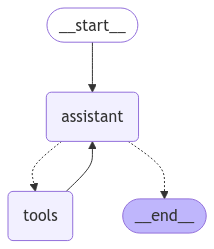

In [7]:
from IPython.display import Image, display
from langgraph.graph import END, START, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

Let's test the workflow now with an example question.

In [8]:
input_messages = [HumanMessage(content="Who played in the Casino?")]
messages = react_graph.invoke({"messages": input_messages})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Who played in the Casino?
================================== Ai Message ==================================
Tool Calls:
  Information (call_j4usgFStGtBM16fuguRaeoGc)
 Call ID: call_j4usgFStGtBM16fuguRaeoGc
  Args:
    entity: Casino
================================= Tool Message =================================
Name: Information

type:Movie
title: Casino
year: 1995-11-22
ACTED_IN: Robert De Niro, Joe Pesci, Sharon Stone, James Woods
IN_GENRE: Drama, Crime

================================== Ai Message ==================================

The movie "Casino," released in 1995, features the following actors:

- Robert De Niro
- Joe Pesci
- Sharon Stone
- James Woods

The film is in the Drama and Crime genres.
